# <font color=blue>A/B Test Sample Project</font>
### <font color=#4D4D4D>Warren Silva</font>
---

This is a sample A/B testing project. The functions defined below are intended to be highly reusable, and are designed with the flexibility to accept data sets with either a binary or a continuous target variable. The example project that follows will analyze both scenarios. The key features of this script include:

- **<font color=orange>Programmatic detection of target variable variety (binary or continuous)</font>**
- **<font color=orange>Conditional execution of appropriate statistical tests based on sample size, distribution type</font>**
- **<font color=orange>Interpretation logic for accepting/rejecting the null hypothesis of group similarity</font>**

## <font color=blue>Campaign Overview and Objectives</font>
---
*The scenario and company referenced here are fictitious, as is the data. The sample was generated using a script developed by the author.*

A retail website routinely offers the same promotion to 
first-time visitors, to drive purchase activity. They recently ran a campaign where new visitors were randomly offered an alternative promotion. The campaign aims to uncover two things:
1. **<font color=blue>Which promotion leads to a higher rate of purchase?</font>**
2. **<font color=blue>Among visitors who make a purchase, which group spends more?</font>**

## <font color=blue>Analysis and Test Execution</font>
---

First, we import the necessary libraries, load and preview the data.

In [4]:
# import libraries and config
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
import scipy.stats as stats
import seaborn as sb
import matplotlib.pyplot as plt

# load and preview data
df = pd.read_csv('sample_data.csv')
df.head()

,id,date,group,outcome
0,aa100291,8/15/23,treatment,0.000
1,aa101685,11/26/23,treatment,0.000
2,aa102878,12/26/23,control,0.000
3,aa102922,9/14/23,control,0.000
4,aa103178,12/25/23,treatment,0.000


<u>Data Description</u>

- <code>id</code> - Unique identifier for visitor
- <code>date</code> - Date of visit
- <code>group</code> - Indicator for which promotion was offered:
    - A value of 'control' means the standard promotion was offered
    - A value of 'treatment' means the alternative promotion was offered
- <code>outcome</code> - The amount spent on the current visit

Recall that we have two questions to answer, which means we will ultimately run two seperate A/B tests, each with the appropriate target variable: 

> **<font color=blue>1. Which promotion leads to a higher rate of purchase?</font>**
>> For this first question, we will need to create a binary indicator to distinguish purchases from non-purchases.

> **<font color=blue>2. Among visitors who make a purchase, which group spends more?</font>**   
>> The existing <code>outcome</code> variable will satisfy the need for this one.

To aid with question #1, we'll add a variable called <code>did_purchase</code> and set the value to **<font color=green>1</font>** (True) if a purchase was made, otherwise we set the value to **<font color=green>0</font>** (False).

In [7]:
# binary indicator for purchase
df['did_purchase'] = np.where(df['outcome'] > 0, 1, 0)
df.sample(5)

,id,date,group,outcome,did_purchase
98127,zn39691,12/25/23,treatment,0.000,0
93755,yj81690,8/23/23,treatment,0.000,0
46844,me62097,10/3/23,treatment,0.000,0
3444,ax149660,10/5/23,control,0.000,0
76350,tv149018,9/23/23,control,0.000,0


Next, we'll get some more detailed summary statistics about our data.

In [9]:
# summary stats function
def summarize(df):
    # summary dataframes
    df_type = pd.DataFrame(df.dtypes, columns=['data type'])
    df_null = pd.DataFrame(df.isnull().sum(), columns=['null_count'])
    df_null['null_pct'] = df.isnull().mean() * 100
    df_unique = pd.DataFrame(df.nunique(), columns=['unique'])
    df_stats = df.describe(include='all').transpose()
    df_stats = df_stats[['top', 'freq', 'min', 'max', 'mean', 'std']]
    
    # combine
    df_summary = pd.concat([df_type, df_null, df_unique, df_stats], axis=1)
    
    # add dup row count
    duplicate_rows = df.duplicated().sum()
    df_summary.loc['duplicate rows'] = duplicate_rows
    
    # print results
    print(f'record count: {df.shape[0]}')
    print(f'column count: {df.shape[1]}')
    print()
    print('Data Summary:')
    display(df_summary)
    
    return None

# get summary stats
summarize(df)

record count: 100000
column count: 5

Data Summary:


,data type,null_count,null_pct,unique,top,freq,min,max,mean,std
id,object,0,0.000,99100,or71985,3,NaN,NaN,NaN,NaN
date,object,0,0.000,152,8/8/23,729,NaN,NaN,NaN,NaN
group,object,0,0.000,2,treatment,51628,NaN,NaN,NaN,NaN
outcome,float64,0,0.000,3645,NaN,NaN,0.000,2279.774,3.385,23.882
did_purchase,int32,0,0.000,2,NaN,NaN,0.000,1.000,0.036,0.187
duplicate rows,3,3,3.000,3,3,3,3,3,3,3


<u>Observations</u>
- Control and treatment groups are reasonably balanced with the treatment group representing a little over 51% of the data
- There are fewer unique <code>id</code> values than there are total records, which suggests that there are multiple records for some visitors.
- There are also a few records where all values are duplicated.
- There is a large difference between the mean and the max outcome, suggesting we probably have some extreme outliers in our data.

We'll do a little bit of cleaning with the information uncovered from these stats. 

Firstly, since the business problem is concerned with first-time visitors only, we will drop records for subsequent visits for the same <code>id</code> value, keeping only the record with the earliest <code>date</code> value.

In [12]:
# keep only first visit for each unique id
df = df.sort_values(['id', 'date'])
df = df.drop_duplicates(subset='id', keep='first').reset_index(drop=True)

Let's get a little bit of a more detailed picture of how <code>outcome</code> (purchase amount) is distributed. To focus in on the business problem, we'll look at only records where there was a sale.

In [14]:
df_sales = df[df['did_purchase']==1] #.reset_index(drop=True)
df_sales['outcome'].describe()

#df[df['outcome']>0]['outcome'].describe()

count   3618.000
mean      92.885
std       85.895
min        5.093
25%       47.222
50%       88.692
75%      133.121
max     2279.774
Name: outcome, dtype: float64

We can see that the average sale amount is about \\$92, and 75\% of sales are \\$133 or below. But in rarer cases, some visitors spend much, much more. Let's visualize some of these outliers to get a better sense of just how rare these cases are.

In [16]:
# boxplot function
def make_boxplot(dataframe, top_val=None):
    plt.figure(figsize=(4, 7))
    # set color for outliers
    flierprops = dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none')
    ax = sb.boxplot(data=dataframe, whis=2.0, color='blue', flierprops=flierprops)
    if top_val:
        ax.set_ylim(bottom=1, top=top_val)

    # set color for IQR and whiskers
    for patch in ax.artists:
        patch.set_edgecolor('blue')
        patch.set_facecolor('blue')
    for line in ax.lines:
        line.set_color('blue')
    plt.show()

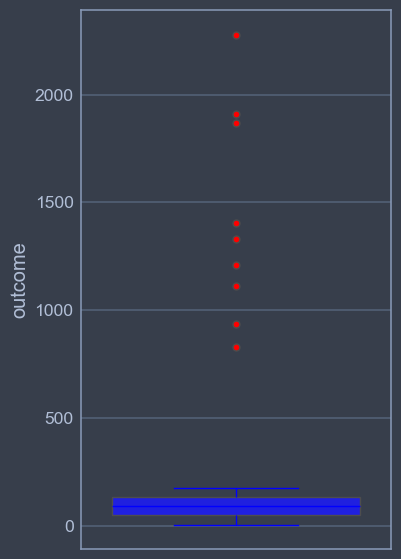

In [17]:
make_boxplot(df_sales['outcome'])

Visually, we can pretty easily see that there are just a handful of pretty extreme values relative to the bulk of the data. Let's try focusing in on the more common outcomes. We'll do this by providing a value for the <code>top</code> argument we built into our boxplot function.

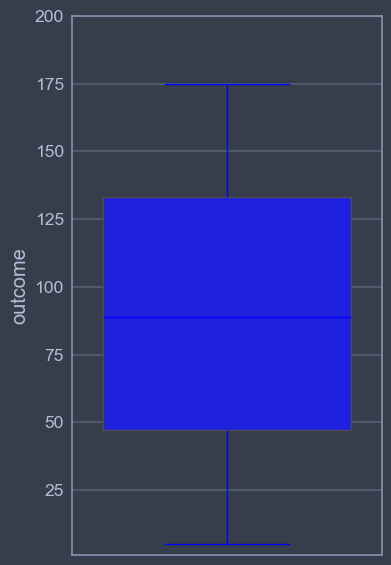

In [19]:
make_boxplot(df_sales['outcome'], 200)

That gives a much clearer picture of how the majority of the sales are distributed. 

Here is a brief overview of how we interpret the boxplot:
- The solid area of the boxplot represents the interquartile range (IQR), which spans everything between the 25th and 75th percentile. More simply, it is the "middle half" of the data.
- The lines, or "whiskers" that extend above and below the IQR are meant to capture everything that falls within a "reasonable" distance from the mean. In this case we have defined "reasonable distance" as twice the size of the IQR (by passing <code>whis=2.0</code> to our boxplot function), which is a common threshold when considering the statistical dispersion of continuous data that might contain outliers. 

We can easily see that the vast majority of sales are under about \\$175, and the interquartile range, representing everything between the 25th and 75th percentile, includes sales roughly between \\$50 and \\$130.  If we want to get some more precise numbers for the sake of discussion, we can calculate those:

In [21]:
# calculate IQR and related components
q1 = df_sales['outcome'].quantile(0.25)
q3 = df_sales['outcome'].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - 2 * iqr
upper_limit = q3 + 2 * iqr
lower_whis = df_sales['outcome'][df_sales['outcome'] >= lower_limit].min()
upper_whis = df_sales['outcome'][df_sales['outcome'] <= upper_limit].max()

print(f'Lowest reasonable actual value: ${lower_whis:.2f}')
print(f'25th percentile: ${q1:.2f}')
print(f'75th percentile: ${q3:.2f}')
print(f"Highest reasonable actual value: ${upper_whis:.2f}")

Lowest reasonable actual value: $5.09
25th percentile: $47.22
75th percentile: $133.12
Highest reasonable actual value: $174.99


Let's quickly look at the count of our outliers and their ratio to the rest of the data.

In [23]:
# check outlier count and proportion
sales_count = len(df_sales)
outlier_count = len(df_sales[df_sales['outcome']>500])
outlier_pct = (outlier_count / sales_count) * 100

print(f'There are {outlier_count} outliers out of {sales_count} sales, representing {outlier_pct:.3f}% of the data')

There are 9 outliers out of 3618 sales, representing 0.249% of the data


As suspected, these outliers represent a very rare case, and it makes sense to remove them from our analysis so as not to skew the results of our test or any calculations for mean sales, which we are likely to be interested in when presenting our outcomes.

In [25]:
# focus on purchases
#df_sales = df[df['outcome']>0][['outcome']]

#make_boxplot(df_sales)

In [26]:
#make_boxplot(df_sales, 200)

The outliers in this problem may seem pretty cut and dry, but that is not always the case. In the event we wanted to take a more programmatic approach to outlier detection and pruning, here is an alternative method that utilizes z_score.

Rejection of 9 points
A z-score of 3 corresponds to a probability of 0.27%


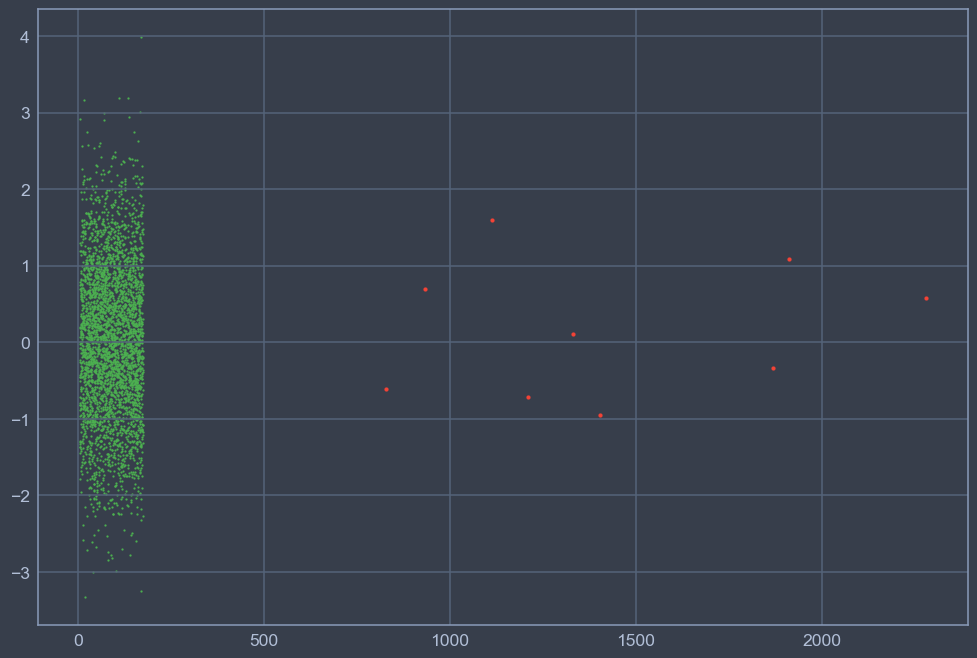

In [28]:
d1 = df_sales['outcome'].values

mean = np.mean(d1)
std = np.mean(d1)
z_score = np.abs((d1 - mean) / std)
threshold = 3
good = z_score < threshold

print(f'Rejection of {(~good).sum()} points')
print(f'A z-score of {threshold} corresponds to a probability of {100 * 2 * stats.norm.sf(threshold):0.2f}%')

visual_scatter = np.random.normal(size=d1.size)
plt.figure(figsize=(12, 8))
plt.scatter(d1[good], visual_scatter[good], s=2, label='Good', color='#4CAF50')
plt.scatter(d1[~good], visual_scatter[~good], s=8, label='Bad', color='#F44336')
plt.show()

In [29]:
# drop outliers
outlier_indices = df_sales.index[~good]
df = df.drop(outlier_indices).reset_index(drop=True)
df_sales = df_sales.drop(outlier_indices).reset_index(drop=True)

## <font color=blue>Run A/B Tests</font>
---
Here we have a function that will handle our A/B test, including:
- normality test
- <font color=red>ETC...</font>

In [31]:
# a/b testing function for binary or continuous targets
def ab_test(df_in, group, target):
    # split a/b populations
    df_a = df_in[df_in[group] == 'treatment'][target]
    df_b = df_in[df_in[group] == 'control'][target]
    
    # check if the target variable is binary
    is_binary = df_in[target].nunique() == 2
    
    if is_binary:
        print('Target variable is binary') 
        
        # create contingency table
        contingency_table = pd.crosstab(df_in[group], df_in[target])
        
        # decide between Chi-Square and Fisher's Exact test based on sample size 
        if df_in.shape[0] >= 1000:
            print('Running Chi-Square test (sample size is >= 1000)')
            chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
            test_type = 'Chi-Square Test'
        else:
            print('Running Fisher\'s Exact test (sample size is < 1000)')
            _, p_value = stats.fisher_exact(contingency_table)
            test_type = 'Fisher\'s Exact Test'
        
        # interpret results
        ab_hypothesis = 'Reject H0' if p_value < 0.05 else 'Fail to Reject H0'
        comment = 'A/B groups are not similar!' if ab_hypothesis == 'Reject H0' else 'A/B groups are similar!'
        
        # output dataFrame
        df_out = pd.DataFrame({
            'Test Type': [test_type],
            'AB Hypothesis': [ab_hypothesis],
            'p-value': [p_value],
            'Comment': [comment]
        })
    
    else:
        # normality test
        if (len(df_a) < 5000) & (len(df_b) < 5000):
            print('Running Shapiro-Wilk normality test (sample size is < 5000)')
            norm_a = stats.shapiro(df_a)[1] < 0.05
            norm_b = stats.shapiro(df_b)[1] < 0.05
        else:
            print('Running Kolmogorov-Smirnov normality test (sample size is > 5000)')
            norm_a = stats.kstest(df_a, 'norm')[1] < 0.05
            norm_b = stats.kstest(df_b, 'norm')[1] < 0.05

        if (norm_a == False) & (norm_b == False):  # Parametric Test
            leveneTest = stats.levene(df_a, df_b)[1] < 0.05
            if leveneTest == False:
                ttest = stats.ttest_ind(df_a, df_b, equal_var=True)[1]
            else:
                ttest = stats.ttest_ind(df_a, df_b, equal_var=False)[1]
        else:
            # non-parametric test
            ttest = stats.mannwhitneyu(df_a, df_b)[1]

        # result for continuous data
        df_out = pd.DataFrame({
            'AB Hypothesis': [ttest < 0.05],
            'p-value': [ttest]
        })
        df_out['Test Type'] = np.where((norm_a == False) & (norm_b == False), 'Parametric', 'Non-Parametric')
        df_out['AB Hypothesis'] = np.where(df_out['AB Hypothesis'] == False, 'Fail to Reject H0', 'Reject H0')
        df_out['Comment'] = np.where(df_out['AB Hypothesis'] == 'Fail to Reject H0', 'A/B groups are similar!', 'A/B groups are not similar!')

        # additional homogeneity column for parametric tests
        if (norm_a == False) & (norm_b == False):
            df_out['Homogeneity'] = np.where(leveneTest == False, 'Yes', 'No')
            df_out = df_out[['Test Type', 'Homogeneity', 'AB Hypothesis', 'p-value', 'Comment']]
        else:
            df_out = df_out[['Test Type', 'AB Hypothesis', 'p-value', 'Comment']]
    
    return df_out

Before data cleaning
- control mean 3.54120
- treatment mean 3.23828
- p-value 0.02691

In [33]:
# reset display format 
##### (precision????) #####
pd.options.display.float_format = '{:.5f}'.format

It's finally time to answer our business questions, starting with:
> **<font color=blue>Which promotion leads to a higher rate of purchase?</font>**


In [35]:
# run A/B test on purchase rate
ab_test(df, 'group', 'did_purchase')

Target variable is binary
Running Chi-Square test (sample size is >= 1000)


,Test Type,AB Hypothesis,p-value,Comment
0,Chi-Square Test,Reject H0,0.02273,A/B groups are not similar!


In [36]:
print()
display(df.groupby('group')['did_purchase'].mean())

group
control     0.03783
treatment   0.03510
Name: did_purchase, dtype: float64

And to answer our second question:
> **<font color=blue>Among visitors who make a purchase, which group spends more?</font>**

In [41]:
# run A/B test on purchase amount
ab_test(df_sales, 'group', 'outcome')

Running Shapiro-Wilk normality test (sample size is < 5000)


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.19797,A/B groups are similar!


In [42]:
print()
display(df_sales.groupby('group')['outcome'].mean())

group
control     88.51839
treatment   90.58553
Name: outcome, dtype: float64